# Data modelling and model building

Building data models to predict pollution

## Data loading and preparation

In [1]:
import pandas as pd
# Load the data
data = pd.read_csv('../Combined data/combined_data_hourly_2023.csv')

data = data.iloc[:, :11].join(data[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
print(data.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data['Weekday'] = data['Weekday'].astype('category')
data['Hour'] = data['Hour'].astype('category')

print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8758 entries, 0 to 8757
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             8758 non-null   object 
 1   Hour                8758 non-null   int64  
 2   NO2_ppb             8649 non-null   float64
 3   NOx_ppb             8497 non-null   float64
 4   Temp_dry            8757 non-null   float64
 5   Humidity            8757 non-null   float64
 6   wind_speed          8757 non-null   float64
 7   Pressure            8757 non-null   float64
 8   visibility          8758 non-null   float64
 9   Wind_dir            8757 non-null   float64
 10  Traffic east        8758 non-null   float64
 11  Traffic north-east  8758 non-null   float64
 12  Traffic south-east  8758 non-null   float64
 13  Traffic Hvidovre    8758 non-null   float64
 14  Traffic north-west  8758 non-null   float64
 15  Traffic south-west  8758 non-null   float64
 16  Traffi

In [2]:
# Ensure the 'Wind_dir' column is numeric before categorization
data['Wind_dir'] = pd.to_numeric(data['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data['Wind_dir'] = data['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data['Wind_dir'] = data['Wind_dir'].astype('category')

In [3]:
# show the levels of the 'Weekday' column
print(data['Weekday'].cat.categories)
print(data['Hour'].cat.categories)
print(data['Wind_dir'].cat.categories)

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64')
Index(['E', 'N', 'NE', 'NW', 'S', 'SE', 'SW', 'W'], dtype='object')


Missing values

Missing values count in each column:
Weekday                 0
Hour                    0
NO2_ppb               109
NOx_ppb               261
Temp_dry                1
Humidity                1
wind_speed              1
Pressure                1
visibility              0
Wind_dir                0
Traffic east            0
Traffic north-east      0
Traffic south-east      0
Traffic Hvidovre        0
Traffic north-west      0
Traffic south-west      0
Traffic west            0
dtype: int64


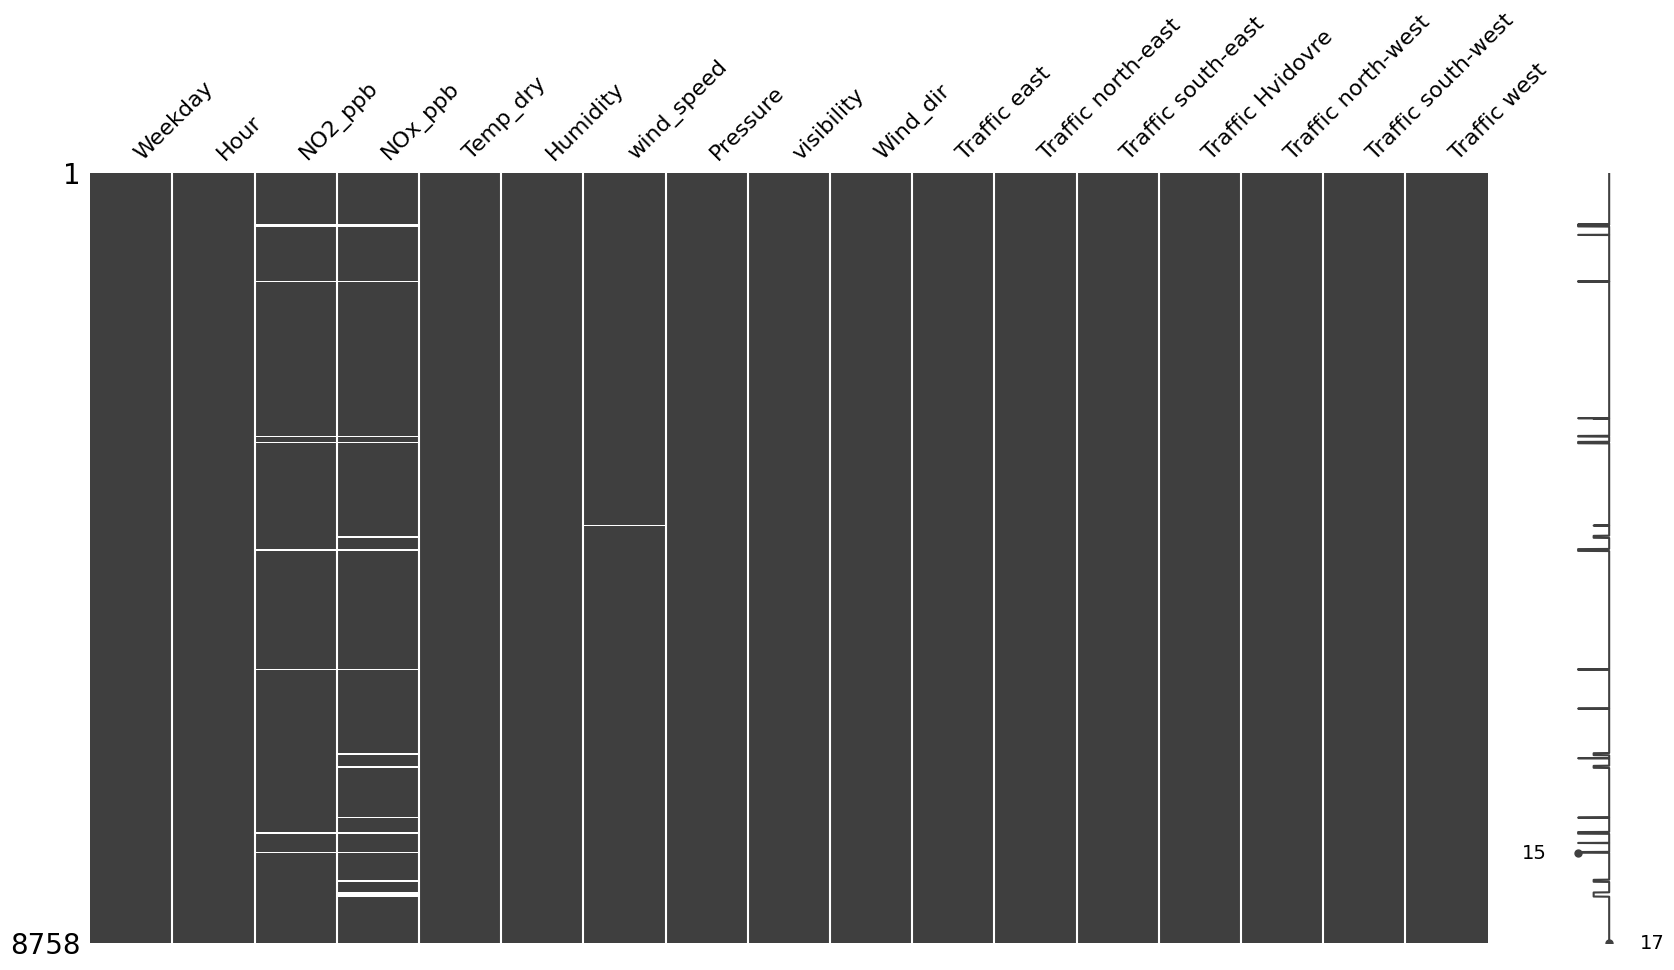

Data after dropping rows with missing values:
Weekday               0
Hour                  0
NO2_ppb               0
NOx_ppb               0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64


C:\Users\simon\AppData\Local\Temp\ipykernel_9192\1868761441.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NO2_ppb'].fillna(data['NO2_ppb'].mean(), inplace=True)
C:\Users\simon\AppData\Local\Temp\ipykernel_9192\1868761441.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [4]:
# Count rows with missing values
missing_values_count = data.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data['NO2_ppb'].fillna(data['NO2_ppb'].mean(), inplace=True)
data['NOx_ppb'].fillna(data['NOx_ppb'].mean(), inplace=True)
data['Temp_dry'].fillna(data['Temp_dry'].mean(), inplace=True)
data['wind_speed'].fillna(data['wind_speed'].mean(), inplace=True)
data['Pressure'].fillna(data['Pressure'].mean(), inplace=True)
data['visibility'].fillna(data['visibility'].mean(), inplace=True)
data['Humidity'].fillna(data['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Consider using KNN to impute missing values instead.

In [5]:
# Transform the categorical variables into dummy variables
data = pd.get_dummies(data, drop_first=True)
print(data.head())

    NO2_ppb    NOx_ppb   Temp_dry   Humidity  wind_speed     Pressure  \
0  9.609539  14.333718   8.083333  98.500000    5.600000  1000.050000   
1  2.431203   2.601390   9.516667  97.500000    6.600000   999.616667   
2  1.794863   1.888760  10.200000  95.000000   10.633333   999.666667   
3  1.286549   1.169177  10.033333  95.666667   10.300000   999.866667   
4  1.020709   0.850521  10.166667  95.000000   10.300000  1000.300000   

    visibility  Traffic east  Traffic north-east  Traffic south-east  ...  \
0  3600.000000          3.73                8.40                0.93  ...   
1  4250.000000          1.87                5.60                0.93  ...   
2  4550.000000          0.93                3.73                0.93  ...   
3  3566.666667          0.00                2.80                0.00  ...   
4  3650.000000          0.00                0.93                0.00  ...   

   Hour_21  Hour_22  Hour_23  Wind_dir_N  Wind_dir_NE  Wind_dir_NW  \
0    False    False    False

Splitting into training and testing set.

In [6]:
# X and Y. X should be all variables except NO2_ppb, and Y should be NO2_ppb
X = data.drop(columns=['NO2_ppb', 'NOx_ppb'])
y = data['NO2_ppb']

# Split the data into training and testing sets
split_index = int(len(X) * 0.8)

# Chronological split, which is possible as the data is already in order
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

Data visualization

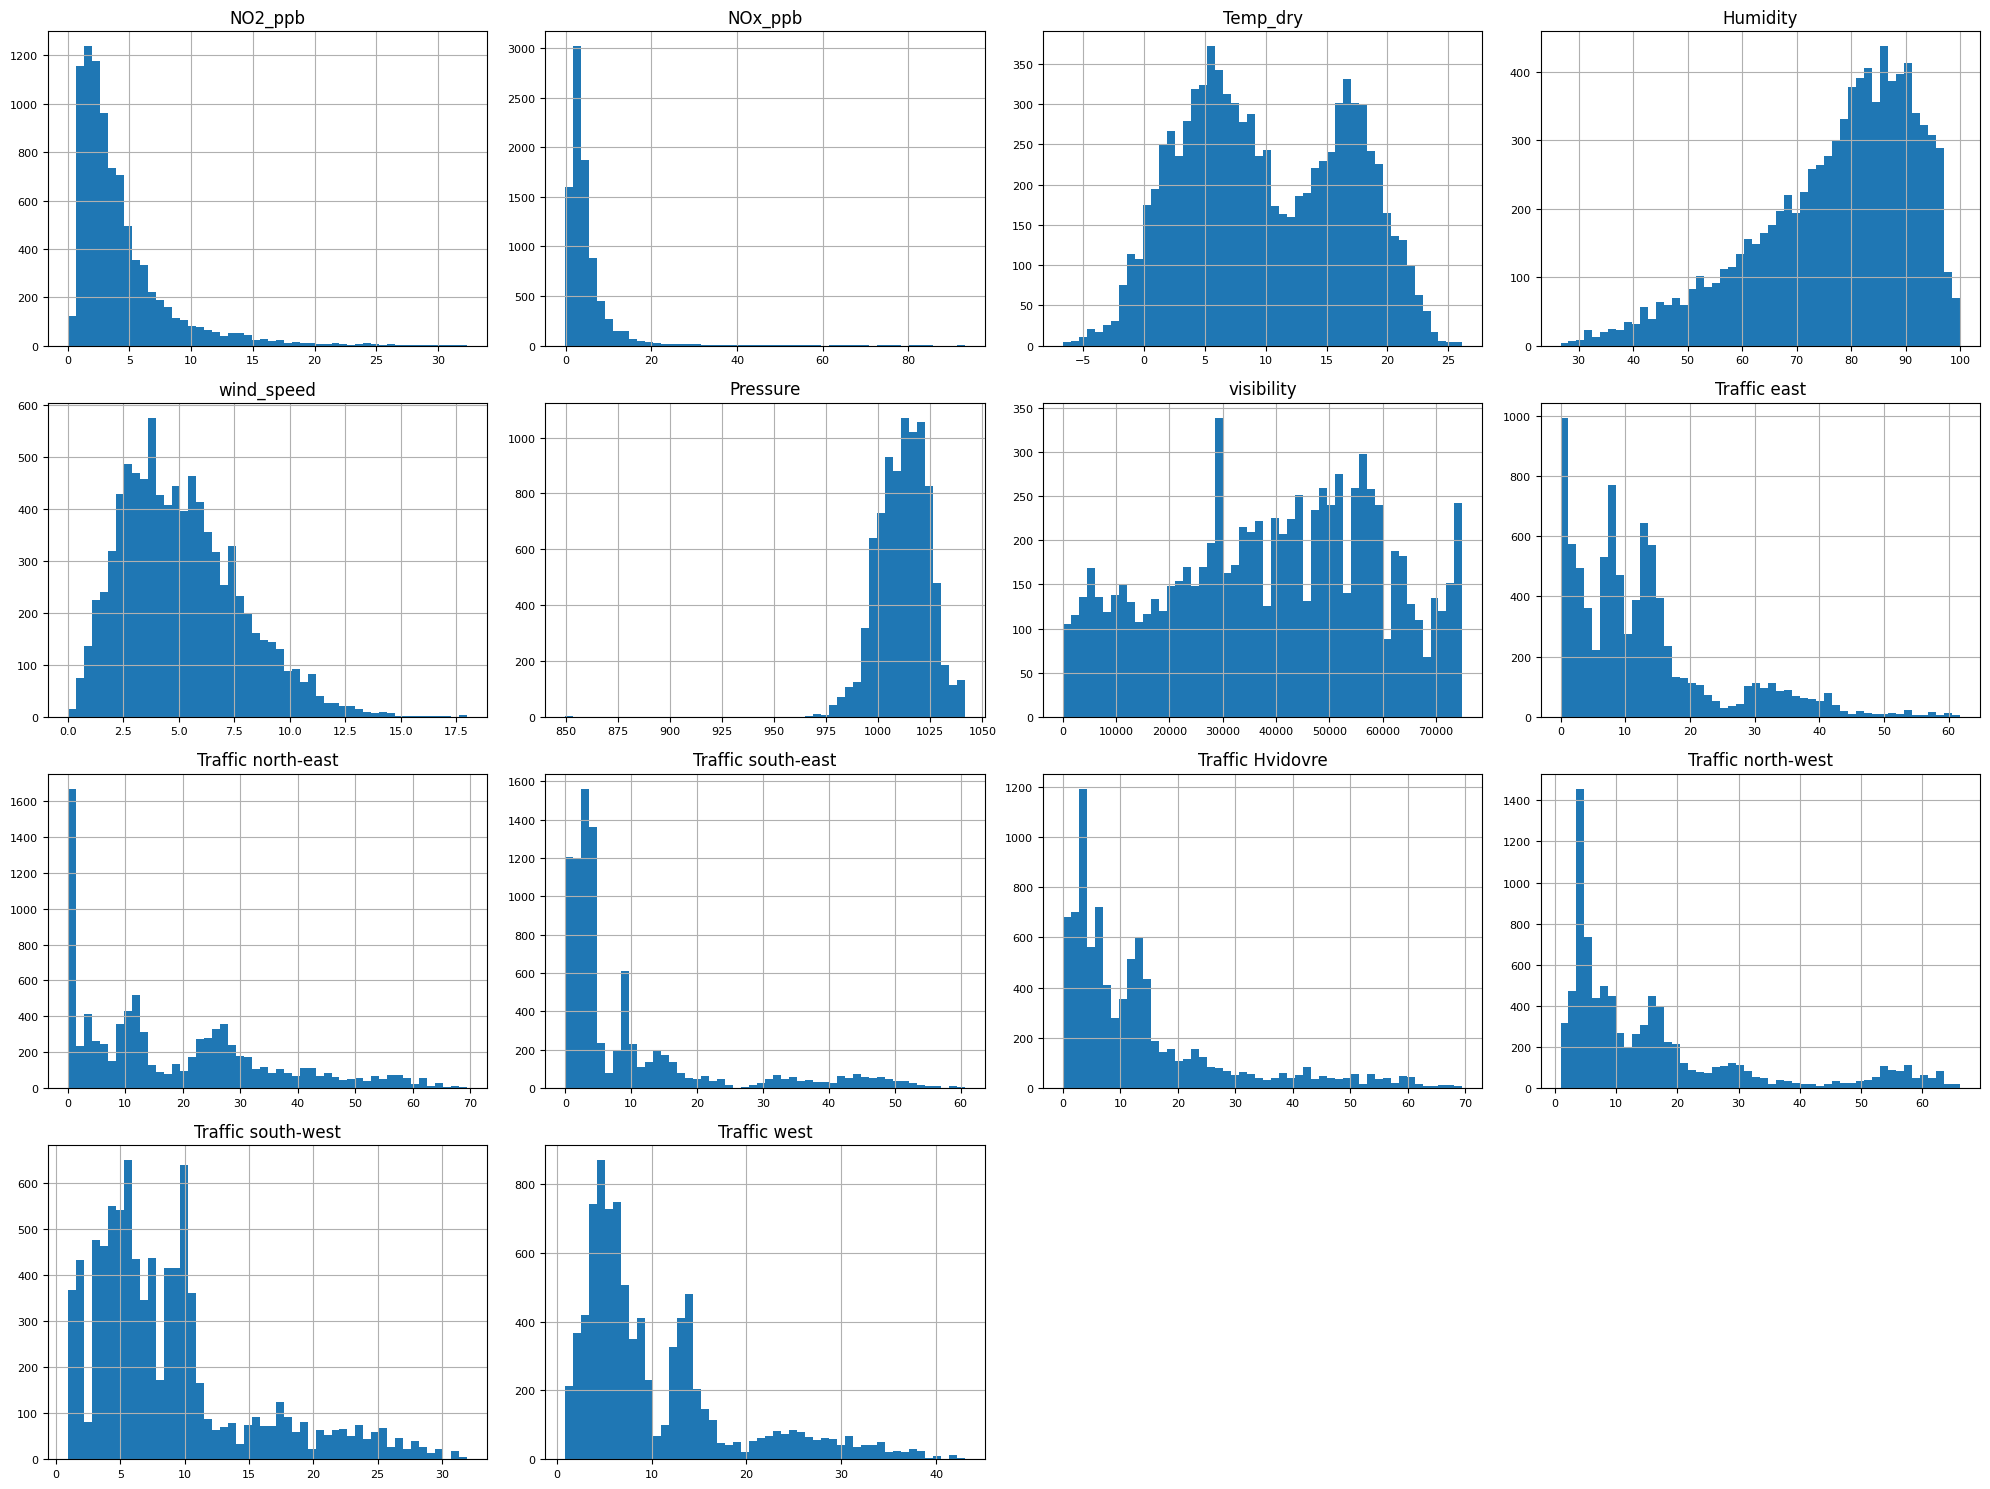

In [7]:
# Visualize the numeric data with histograms
data.hist(figsize=(20, 15), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()

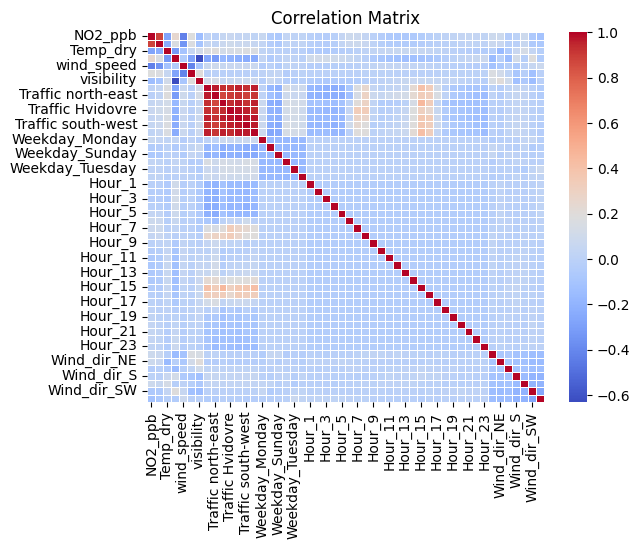

In [8]:
import seaborn as sns
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

As it can be seen, there are a lot of multicollinearity to be found among the different traffic variables, which can prove to be a problem for the final model.

## Modelling

### Linear regression

In [9]:
from sklearn.linear_model import LinearRegression    # Requires package scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

import statsmodels.api as sm

# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

# Fit the model using statsmodels
ols_model = sm.OLS(y_train, X_train_const.astype(float)).fit()

# Print the coefficients and their p-values
print(ols_model.summary())

Mean Squared Error: 9.221375944414339
                            OLS Regression Results                            
Dep. Variable:                NO2_ppb   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     93.97
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        13:31:47   Log-Likelihood:                -17718.
No. Observations:                7006   AIC:                         3.553e+04
Df Residuals:                    6957   BIC:                         3.587e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

### Linear Stepwise Regression

### KNN

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define pipeline with scaling + KNN model
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Since KNN is distance-based the variables will be standard scaled
    ('knn', KNeighborsRegressor())
])

# Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': list(range(1, 51))  # test k = 1 to 50
}

# Grid search with cross-validation (use TimeSeriesSplit if you want)
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best k:", grid_search.best_params_['knn__n_neighbors'])
print(f"Test MSE: {mse:.2f}")

Best k: 24
Test MSE: 13.57


### PLS

### PCR

### SVM

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Create the SVM regression model
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
svm_y_pred = svm_model.predict(X_test)

# Evaluate the model
svm_mse = mean_squared_error(y_test, svm_y_pred)
print(f"SVM Regression Mean Squared Error: {svm_mse}")

SVM Regression Mean Squared Error: 18.392474696155386


### Random forrest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_y_pred)
print(f"Random Forest Mean Squared Error: {rf_mse}")

Random Forest Mean Squared Error: 8.343084463929678


### XGBOOST!!!

In [39]:
import xgboost as xgb
import numpy as np
from xgboost import XGBRegressor  # or XGBClassifier for classification
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

all_predictions = []
all_actuals = []

for train_idx, val_idx in tscv.split(X_train):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)
    model.fit(X_t, y_t)

    val_pred = model.predict(X_val)

    # Store results
    all_predictions.extend(val_pred)
    all_actuals.extend(y_val)

    mse_scores = mean_squared_error(y_val, val_pred)
    print(f"Fold MSE: {mean_squared_error(y_val, val_pred):.2f}")

# COMMENT BY SIMON: I believe the below code wrong, as it only prints the last fold of MSE. I have left it so you can inspect it. Use the other code (below that) instead (by William).
##########################################################
# Print average MSE
avg_mse = np.mean(mse_scores)
print(f"\nAverage MSE across folds: {avg_mse:.2f}")
##########################################################

# Average MSE across all predictions
from sklearn.metrics import mean_squared_error
avg_mse = mean_squared_error(all_actuals, all_predictions)
print(f"\nAverage MSE across folds: {avg_mse:.2f}")

Fold MSE: 15.30
Fold MSE: 35.46
Fold MSE: 8.84
Fold MSE: 15.04
Fold MSE: 4.91
Fold MSE: 8.83
Fold MSE: 5.01
Fold MSE: 3.41
Fold MSE: 2.35
Fold MSE: 4.74
Fold MSE: 5.65
Fold MSE: 6.32

Average MSE across folds: 6.32

Average MSE across folds: 9.65


Visualizing the results

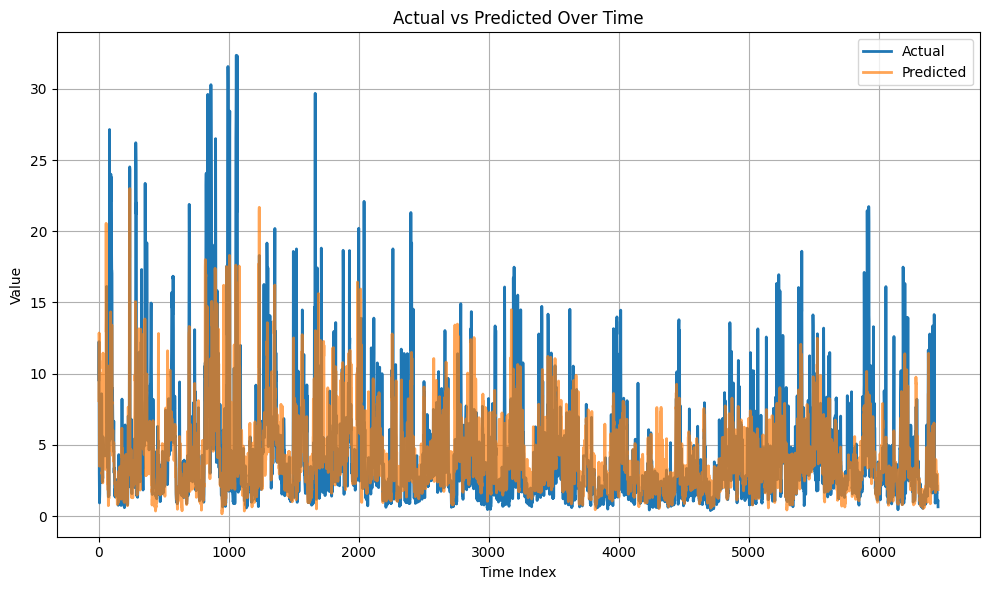


Actual vs Predicted:
      Actual  Predicted
0   9.571613   8.106401
1  12.250150  10.702187
2   4.387977  12.860296
3   3.054045  12.254664
4   1.247701   3.559229
5   0.924189   3.824902
6   1.209380   3.506981
7   1.578022   3.547015
8   3.228724   7.729162
9   5.306948   9.205032


In [40]:
# Code by william
# Optional: convert to DataFrame for easy comparison
comparison_df = pd.DataFrame({
    "Actual": all_actuals,
    "Predicted": all_predictions
})

plt.figure(figsize=(10, 6))
plt.plot(comparison_df["Actual"], label="Actual", linewidth=2)
plt.plot(comparison_df["Predicted"], label="Predicted", linewidth=2, alpha=0.7)
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nActual vs Predicted:")
print(comparison_df.head(10))  # Print first 10 comparisons

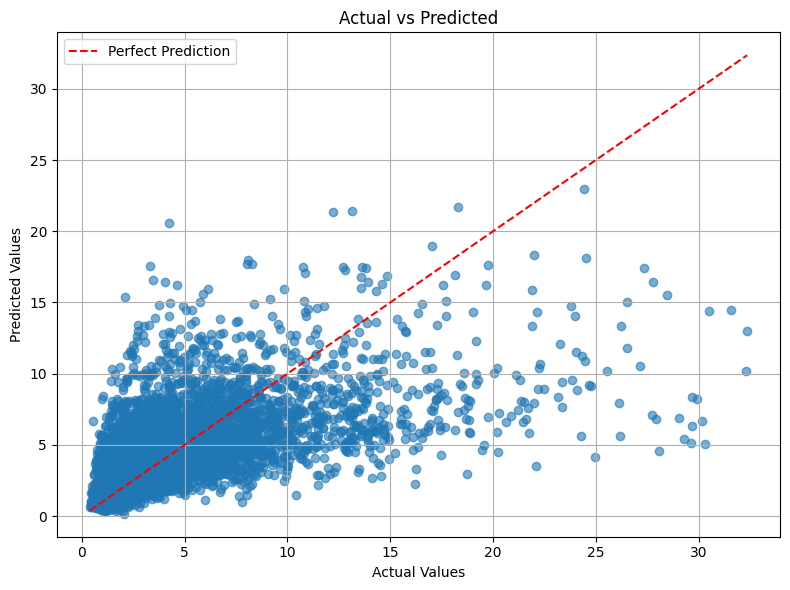

In [ ]:
# This plot could be deleted... shows the residuals
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df["Actual"], comparison_df["Predicted"], alpha=0.6)
plt.plot([comparison_df["Actual"].min(), comparison_df["Actual"].max()],
         [comparison_df["Actual"].min(), comparison_df["Actual"].max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Baseline to beat

The following is a baseline which always guesses the mean.

In [13]:
# Calculate the mean of the training target variable
baseline_prediction = y_train.mean()

# Predict the mean for the test set
y_baseline_pred = [baseline_prediction] * len(y_test)

# Evaluate the baseline model using Mean Squared Error
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
print(f"Baseline Mean Squared Error: {baseline_mse}")

Baseline Mean Squared Error: 15.568077497911679


The MSE is at 15.6, which is significantly higher than our other models. Another baseline could be guessing the same NO2 value as the previous day.

Below is another baseline, which guesses the same NO2 level of the same hour from one day before.

In [15]:
# Create a new dataframe as a copy of the original data
naive_forecast_data = data.copy()

# Create a naive forecast by shifting the NO2_ppb column by 24 hours
naive_forecast_data['NO2_naive_forecast'] = naive_forecast_data['NO2_ppb'].shift(24)

# Drop rows with NaN values caused by the shift
naive_forecast_data = naive_forecast_data.dropna(subset=['NO2_naive_forecast'])

# Evaluate the naive forecast model using Mean Squared Error

naive_mse = mean_squared_error(naive_forecast_data['NO2_ppb'], naive_forecast_data['NO2_naive_forecast'])
print(f"Naive Forecast Mean Squared Error: {naive_mse}")

Naive Forecast Mean Squared Error: 21.797102656616282
